<a href="https://colab.research.google.com/github/UlitiM2/tasks_university/blob/master/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%2C%20%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5/lab3_Ulitina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений и композиции

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pprint import pprint

В этой лабораторной вам предстоит поработать с классификацией. Задача классификации в машинном обучении - это один из основных типов задач, где модель обучается предсказывать категориальную метку или класс для заданного входного наблюдения на основе обучающего набора данных, содержащего пары "входные данные - целевая метка".

Можно выделить несколько видов классификации:

* Binary - целевой признак имеет метку 0/1;
* Multiclass - целевой признак имеет метку из ограниченного множества (0, 1, 2, 3...);
* Multilabel - целевой признак может иметь несколько меток одновременно.

Классификацию можно решать как задачу регрессии (задача предсказания значения из непрерывного множества), затем выбирая порог - всем значениям меньше порога будет присвоена метка 0, всем значениям выше - метка 1.

# Деревья решений

Решающие деревья - алгоритм машинного обучения, с помощью которого можно решать задачи классификации и регрессии. Основная идея алгортитма - это поиск условий принятия решений по тренировочным данным.

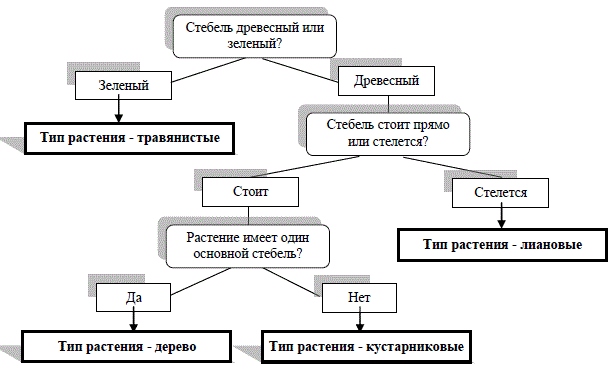

По сути, мы рекурсивно разбиваем наши обучающие данные по значениям определенного столбца, чтобы по итогу в каждом листе оказались наиболее однородные значения целевой переменной.

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$


Небольшое дополнение, чтобы стало понятнее: $Q$ - это функционал, который определяет то, что мы называем "наилучшим разбиением" для данных на каждом шаге. То есть мы выбираем один столбец, потом для него выбираем число $t$ такое, что часть значений столбца меньше $t$, а оставшаяся часть - больше или равна (дерево работает только с числовыми значениями или с категориальными, если они переведены в числовой формат), и смотрим, что случилось с целевой переменной при таком разбиении. Если допустить, что целевая переменная бинарная (0/1) и до разбиения нолики и единички лежали кучей, то после разбиения мы в идеале хотим получить две кучки, где в одной только нули, а в другой только единицы.

## Функционал качества для деревьев решений


Для классификации чаще всего предлагают следующие два:

- энтропия Шеннона: $-\sum_k{p_{ik}log_2(p_{ik})}$

- индекс Джини: $\sum_{j\neq k}p_{ij}p_{ik} = 1 - \sum_k p_{ik}^2$

где $i$ - ID узлов дерева;

$k, j$ - идентификаторы классов, представленных в датасете;

$p_{ik} = \frac{N_{ik}}{N_i}$,

$p_{ik}$ - вероятность принадлежности класса $k$ узлу $i$,

$N_{ik}$ - число объектов класса $k$ в узле $i$,

$N_{i}$ - общее число объектов в узле $i$.



Оба функционала позволяют определить степень хаоса в системе. Интуитивно:
* 0101101010101 - высокая степень хаоса
* 0000010010000 - средняя степень хаоса
* 0000000000000 - низкая степень хаоса

И с помощью дерева для целевой переменной мы хотим добиться чего-то вроде:
0001100011111 -> 00011000 + 11111 -> 000 + 11000 + 11111 -> 000 + 11 + 000 + 11111

Реализуйте функционалы.

In [ ]:
from collections import Counter

def entropy(y):
    if not y:
        return 0.0

    counts = Counter(y)
    total = len(y)
    entropy_value = 0.0

    for count in counts.values():
        p = count / total
        if p > 0:
            entropy_value -= p * np.log2(p)

    return entropy_value

def gini_index(y):
    if not y:
        return 0.0

    counts = Counter(y)
    total = len(y)
    gini = 1.0

    for count in counts.values():
        p = count / total
        gini -= p ** 2

    return gini

In [ ]:
# Tests

assert np.isclose(entropy([0, 1, 0, 1, 0, 1]), 1.0)
assert np.isclose(entropy([0, 0, 0, 0, 0, 1]), 0.65, rtol=1e5)
assert np.isclose(entropy([0, 1, 2, 0, 1, 2, 0, 1, 2]), 1.58, rtol=1e5)

assert np.isclose(gini_index([0, 1, 0, 1, 0, 1]), 0.5)
assert np.isclose(gini_index([0, 0, 0, 0, 0, 1]), 0.27, rtol=1e5)
assert np.isclose(gini_index([0, 1, 2, 0, 1, 2, 0, 1, 2]), 0.66, rtol=1e5)

assert entropy([0, 0, 0, 0, 0, 0]) == gini_index([0, 0, 0, 0, 0, 0]) == 0.0

print("All tests passed successfully!")

All tests passed successfully!


Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


## Задание 1 (5 баллов)

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

В классе `Tree` реализуйте метод `predict` (на вход метода подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою). Обратите внимание на то, что классы в датасете представлены одинаковым количеством объектов.

Один из варинтов того, как может выглядеть дерево (в данном случае переобученное).

Вам не обязательно реализовывать функционал для визуализации, это просто пример. Но если хочется - посмотрите в сторону библиотеки [graphviz](https://graphviz.org/).


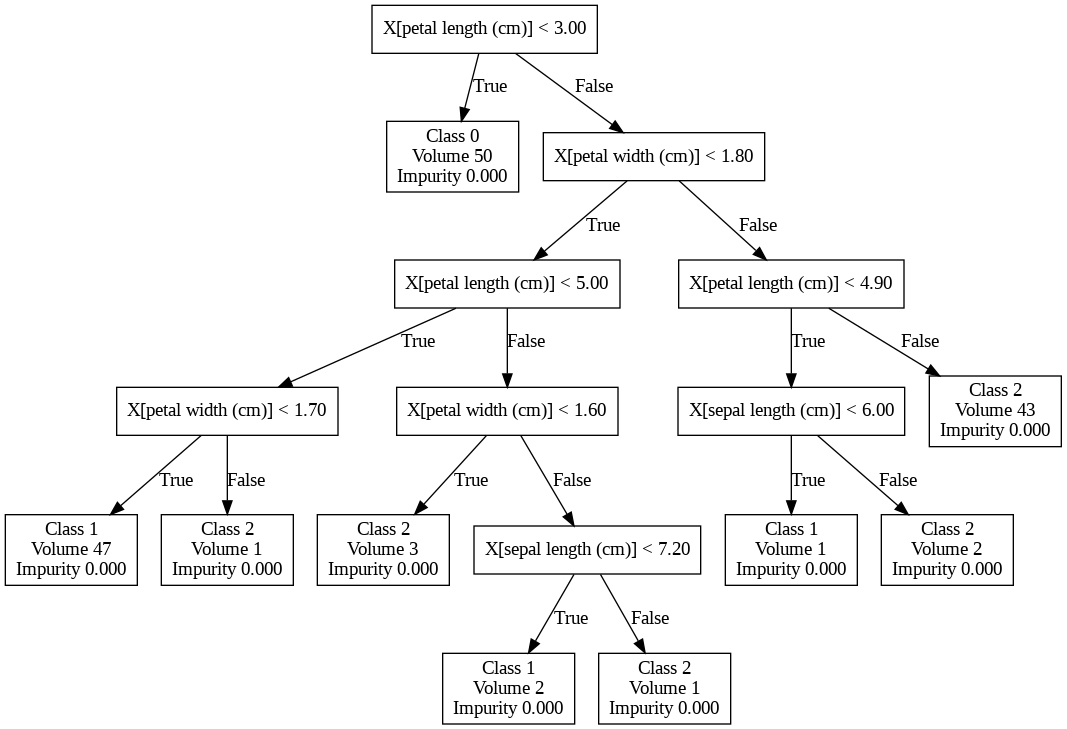

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split  # при оценке вашего алгоритма не забудьте разбить данные на тренировочную и тестовую выборки
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier  # можете сравнить качество вашего алгоритма с реализацией "из коробки"


In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from collections import Counter

class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class Tree:
    def __init__(self, max_depth=5, min_samples_leaf=5, max_leaves=5, purity_stop=True):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_leaves = max_leaves
        self.purity_stop = purity_stop
        self.root = None
        self.n_leaves = 0

    def fit(self, X, y):
        self.n_leaves = 0
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        n_samples = X.shape[0]
        n_features = X.shape[1]

        if len(y) == 0:
            return TreeNode(value=0)

        if self._stop_criteria(y, depth, n_samples):
            leaf_value = self._most_common_label(y)
            self.n_leaves += 1
            return TreeNode(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y, n_features)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            self.n_leaves += 1
            return TreeNode(value=leaf_value)

        left_idxs = X[:, best_feature] <= best_threshold
        right_idxs = ~left_idxs

        if sum(left_idxs) == 0 or sum(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            self.n_leaves += 1
            return TreeNode(value=leaf_value)

        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)

        return TreeNode(best_feature, best_threshold, left, right)

    def _stop_criteria(self, y, depth, n_samples):
        if depth >= self.max_depth:
            return True
        if n_samples < self.min_samples_leaf:
            return True
        if self.n_leaves >= self.max_leaves:
            return True
        if self.purity_stop and len(np.unique(y)) == 1:
            return True
        return False

    def _best_split(self, X, y, n_features):
        best_gain = -1
        best_feature, best_threshold = None, None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature], y, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, feature, y, threshold):
        parent_entropy = self._entropy(y)

        left_idxs = feature <= threshold
        right_idxs = ~left_idxs

        n = len(y)
        n_left, n_right = sum(left_idxs), sum(right_idxs)

        if n_left == 0 or n_right == 0:
            return 0

        e_left = self._entropy(y[left_idxs])
        e_right = self._entropy(y[right_idxs])

        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right
        information_gain = parent_entropy - child_entropy

        return information_gain

    def _entropy(self, y):
        counts = np.bincount(y)
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        if len(y) == 0:
            return 0
        counter = Counter(y)
        most_common = counter.most_common(1)
        return most_common[0][0] if most_common else 0

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


iris = load_iris()
X = iris['data']
y = iris['target']

np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

models = {
    "max_depth=5": Tree(max_depth=5, min_samples_leaf=1, max_leaves=float('inf'), purity_stop=False),
    "min_samples_leaf=5": Tree(max_depth=float('inf'), min_samples_leaf=5, max_leaves=float('inf'), purity_stop=False),
    "max_leaves=5": Tree(max_leaves=11, min_samples_leaf=1, purity_stop=False),
    "purity_stop": Tree(max_depth=float('inf'), min_samples_leaf=1, max_leaves=float('inf'), purity_stop=True)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {accuracy:.4f}")


max_depth=5: Accuracy = 0.9333
min_samples_leaf=5: Accuracy = 0.9333
max_leaves=5: Accuracy = 0.9333
purity_stop: Accuracy = 0.9333


#  [Ансамбли](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)




Суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обобщающей способности или надёжности ансамбля перед одиночным стандартным методом машинного обучения.

Можно выделить следующие типы ансамблирования:

* Бэггинг. Однотипная модель строится по различным подвыборкам обучающих данных, затем результаты аггрегируются, например, с помощью усреднения. Для деревьев решений очень распространенным алгоритмом, использующим идею бэггинга, является случайный лес.

* Бустинг. Строится последовательность однотипных моделей, где каждая следующая призвана исправлять ошибки предыдущих. Самым распространенным алгоритмом бустинга является градиентный бустинг.

* Стэкинг. Строится несколько моделей разного типа, а также мета-модель, делающая итоговое предсказание на основании предсказаний моделей.

Для последующих заданий в качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Обратите внимание, что данные нуждаются в небольшой предобаботке, так как деревья работают только с числовыми признаками.


### Задание 2.1 (2 балла)

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи бэггинга:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализуйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества и другие. Выберите метрику, по которой вы будете сравнивать качество алгоритмов и кратко обоснуйте, почему вы выбрали именно её (в письменном формате).

Нельзя использовать готовую реализацию случайного леса из `sklearn`, но можно сопоставлять с ней качество вашего алгоритма.



Выбрана метрика F1-score, так как:

она устойчива даже если классы распределены неравномерно, учитывает ложные срабатывания


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class RandomForest:
    def __init__(self, n_estimators=100, max_features="sqrt", max_depth=None, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []
        self.classes_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.max_features == "sqrt":
            k = int(np.sqrt(n_features))
        else:
            k = self.max_features
        self.classes_ = np.unique(y)
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X.iloc[indices]
            y_bootstrap = y.iloc[indices]

            tree = DecisionTreeClassifier(
                max_features=k,
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                criterion="gini",
                random_state=np.random.randint(0, 10000)
            )
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("churn.csv")
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
label_encoder = LabelEncoder()
data["Gender"] = label_encoder.fit_transform(data["Gender"])
data = pd.get_dummies(data, columns=["Geography"])

X = data.drop("Exited", axis=1)
y = data["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

custom_rf = RandomForest(max_depth=20)
custom_rf.fit(X_train, y_train)

y_pred_custom = custom_rf.predict(X_test)
print("\nКастомный Random Forest:")
print(f"F1-score: {f1_score(y_test, y_pred_custom):.4f}")

sklearn_rf = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1
)
sklearn_rf.fit(X_train, y_train)
y_pred_sklearn = sklearn_rf.predict(X_test)

print("\nSklearn Random Forest:")
print(f"F1-score: {f1_score(y_test, y_pred_sklearn):.4f}")



Кастомный Random Forest:
F1-score: 0.5927

Sklearn Random Forest:
F1-score: 0.5915


## Задание 2.2 (2 балла)

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента. Можно, например, использовать [SHAP](https://habr.com/ru/companies/wunderfund/articles/739744/) для анализа. Также основные способы для определения важности признаков моделей "из коробки" [описаны здесь](https://machinelearningmastery.com/calculate-feature-importance-with-python/).

In [ ]:
import matplotlib.pyplot as plt

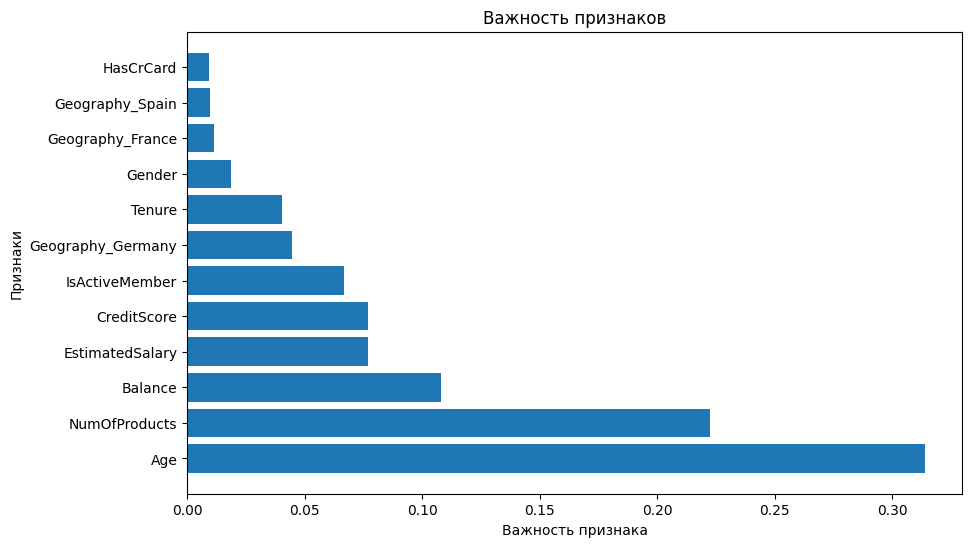

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feature_importances = sklearn_rf.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

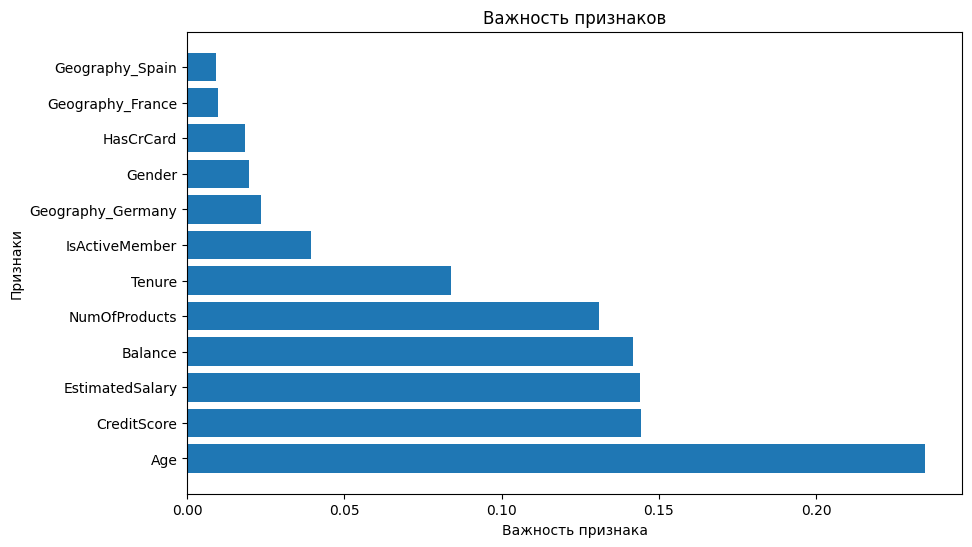

In [ ]:
importances = np.mean([tree.feature_importances_ for tree in custom_rf.trees], axis=0)
features = X.columns

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Важность признака")
plt.ylabel('Признаки')
plt.title("Важность признаков")
plt.show()

In [ ]:
!pip install shap

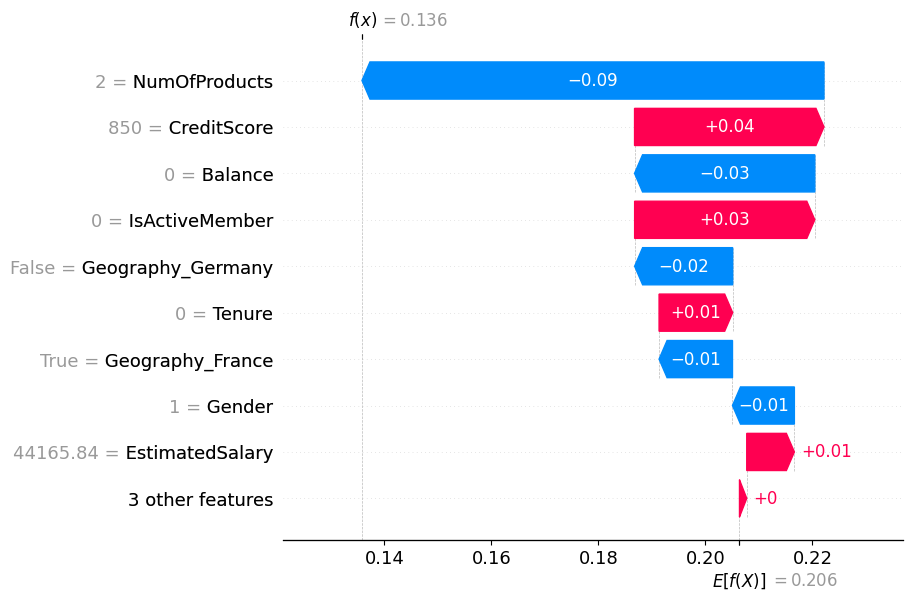

In [ ]:
import shap
explainer = shap.Explainer(sklearn_rf)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0, :, 1])

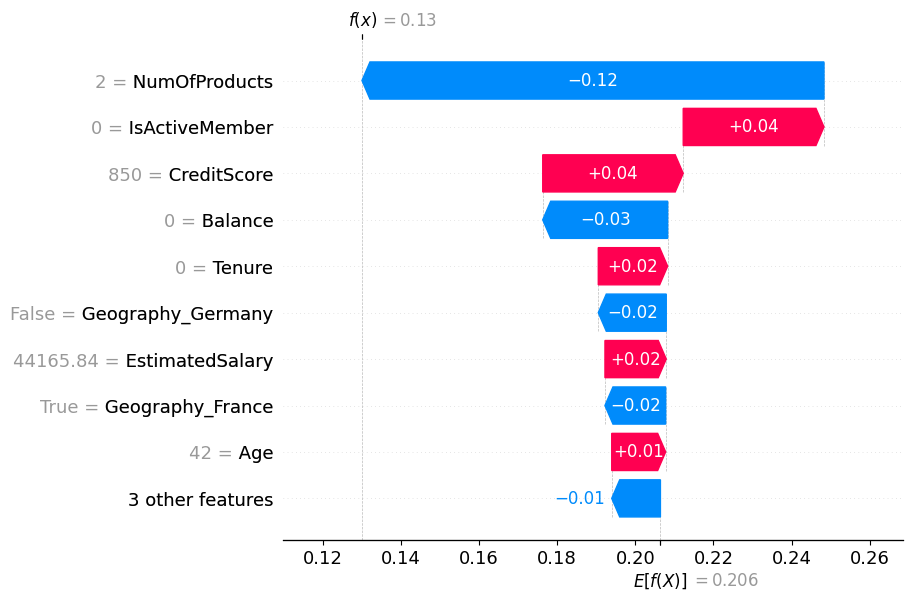

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def convert_to_sklearn(custom_rf):
    sklearn_rf = RandomForestClassifier(
        n_estimators=custom_rf.n_estimators,
        max_depth=custom_rf.max_depth,
        random_state=42
    )
    sklearn_rf.estimators_ = custom_rf.trees
    sklearn_rf.classes_ = custom_rf.classes_
    return sklearn_rf

sklearn_rf_1 = convert_to_sklearn(custom_rf)
explainer = shap.TreeExplainer(sklearn_rf_1)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0, :, 1])

## Задание 3.1 (3 балла)

Вам необходимо будет реализовать алгоритм градиентного бустинга. В общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Для работы алгоритма помимо данных нужны:
1. количество итераций $M \in \mathbb{N}$;
2. функция потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (или просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой делается бустинг - будем использовать деревья решений;
4. начальное приближение $f_0(x)$ - чаще всего используют некую константу.

**Алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно для $t$ от 1 до $M$:
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Находим оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$
    4. Обновляем текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
    5. Собираем все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$
    
    
  Коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице. Однако подбор коэффициентов позволит получить более точные значения, хотя и дополнительно нагрузит алгоритм с вычислительной точки зрения. Коэффициенты выбираются из какого-либо подмножества значений от -1 до 1.

**Функции потерь:**
- $L(y, f) = \frac{1}{2}(y - f)^2$ - _MSE-loss_. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - _MAE-loss_. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать.
- $\begin{equation} L(y, f) =\left\{ \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & \largeесли\ y-f \leq 0 \\ \alpha \cdot |y - f|, & \largeесли\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - $L_q$-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.


Реализуйте предложенные функции потерь и их градиенты. В случае, если в вашей выборке не один объект, не забывайте нормировать значения функции потерь.


In [ ]:
def mse(y_real, y_predicted):
    return np.mean((y_real - y_predicted)**2)

def mse_gradient(y_real, y_predicted):
    return -2*(y_real - y_predicted)

def mae(y_real, y_predicted):
    return np.mean(np.abs(y_real - y_predicted))

def mae_gradient(y_real, y_predicted):
    return -np.sign(y_real - y_predicted)

def lq(y_real, y_predicted, q):
    errors = y_real - y_predicted
    return np.mean(np.where(errors <= 0, (1 - q) * np.abs(errors), q * np.abs(errors)))

def lq_gradient(y_real, y_predicted, q=0.5):
    errors = y_real - y_predicted
    return np.where(errors > 0, -(1-q), np.where(errors < 0, q, 0))

In [ ]:
y_real = np.array([1, 2, 3, 4, 5])
y_predicted = np.array([1.2, 2.5, 2.8, 3.9, 5.1])

# Calculate metrics
mse_result = mse(y_real, y_predicted)
mae_result = mae(y_real, y_predicted)
lq_result = lq(y_real, y_predicted, q=0.8)

# Calculate gradients
mse_grad = mse_gradient(y_real, y_predicted)
mae_grad = mae_gradient(y_real, y_predicted)
lq_grad = lq_gradient(y_real, y_predicted, q=0.8)

# Tests
assert np.isclose(mse_result, 0.07)
assert np.isclose(mae_result, 0.21, rtol=1e5)
assert np.isclose(lq_result, 0.08, rtol=1e5)
assert np.allclose(mse_grad, np.array([0.4, 1, -0.4, -0.2, 0.2]))
assert np.allclose(mae_grad, np.array([1, 1, -1, -1, 1]))
assert np.allclose(lq_grad, np.array([0.8, 0.8, -0.2, -0.2, 0.8]))

print("Tests passed successfully!")

Tests passed successfully!


Реализуйте алгоритм градиентного бустинга со следующими параметрами:

* список, в котором вы будете хранить обученные деревья;
* параметры конструктора для деревьев (tree_kwargs);
* функция потерь;
* градиент функции потерь;
* bool параметр, означающий, является ли $\rho_i$ константой (единицей).

И методами:
* `fit` - в рамках этого метода вам необходимо будет строить деревья. Не забывайте передавать tree_kwargs;
* `predict` - этот метод должен последовательно применить обученные деревья для получения итогового ответа.

В качестве базового алгоритма используйте DecisionTreeRegressor из sklearn. Обычно для градиентного бустинга используют так называемые "пеньки" - деревья небольшой глубины. Это связано с тем, что алгоритм должен иметь высокую обобщающую способность и не переобучаться.


In [ ]:
from sklearn.tree import DecisionTreeRegressor

losses = {
    'MSE': (mse, mse_gradient),
    'MAE': (mae, mae_gradient),
    'LQ': (lq, lq_gradient)
}

class GradientTreeBoosting:
    def __init__(self, loss='MSE', n_estimators=100, learning_rate=0.1, constant_rho=True, tree_kwargs=None):
        self.loss_func, self.grad_func = losses[loss]
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.constant_rho = constant_rho
        self.tree_kwargs = tree_kwargs if tree_kwargs else {'max_depth': 3}
        self.trees = []
        self.rhos = []
        self.initial_prediction = None

    def fit(self, X, y, q=0.5):
        if self.loss_func == mse:
            self.initial_prediction = np.mean(y)
        else:
            self.initial_prediction = np.median(y)

        current_pred = np.full_like(y, self.initial_prediction, dtype=float)

        for _ in range(self.n_estimators):
            if self.loss_func == lq:
                residuals = -self.grad_func(y, current_pred, q)
            else:
                residuals = -self.grad_func(y, current_pred)

            tree = DecisionTreeRegressor(**self.tree_kwargs)
            tree.fit(X, residuals)
            tree_pred = tree.predict(X)

            if self.constant_rho:
                rho = 1.0
            else:
                best_rho = 1.0
                best_loss = float('inf')
                for rho in np.linspace(0.1, 2.0, 20):
                    new_pred = current_pred + self.learning_rate * rho * tree_pred
                    if self.loss_func == lq:
                        loss = self.loss_func(y, new_pred, q)
                    else:
                        loss = self.loss_func(y, new_pred)

                    if loss < best_loss:
                        best_loss = loss
                        best_rho = rho
                rho = best_rho

            current_pred += self.learning_rate * rho * tree_pred
            self.trees.append(tree)
            self.rhos.append(rho)


    def predict(self, X, q=0.5):
        pred = np.full(X.shape[0], self.initial_prediction, dtype=float)

        for tree, rho in zip(self.trees, self.rhos):
            pred += self.learning_rate * rho * tree.predict(X)

        return pred

In [ ]:
gtb = GradientTreeBoosting(loss='MSE', n_estimators=100, learning_rate=0.1, constant_rho=True, tree_kwargs={'max_depth': 3})
gtb.fit(X_train, y_train)

predictions = gtb.predict(X_test)
print(predictions)

[ 0.07075396  0.19724407 -0.00803361 ...  0.04597489  0.65104934
  0.15878459]


## Задание 3.2 (2 балла)

Проверим на игрушечном примере, что алгоритм работает. Если ваша реализация отличается от используемой в примере - поправьте код примера. Но результат должен получаться похожим.

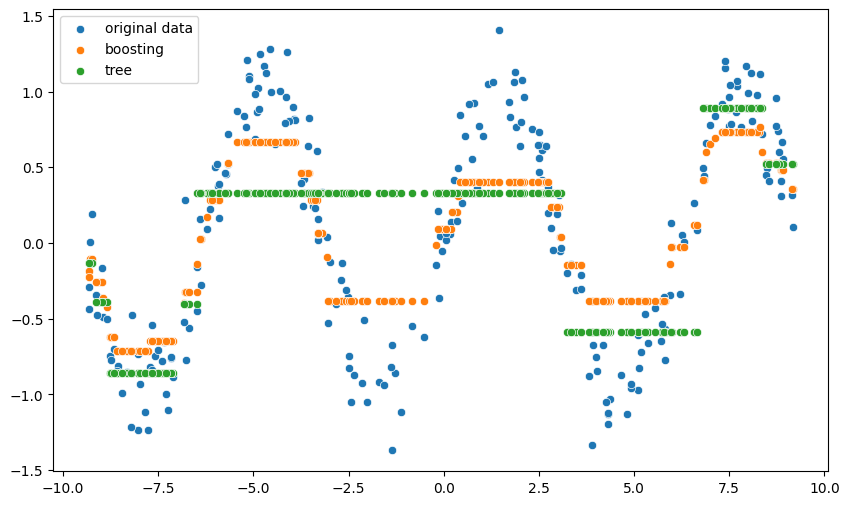

In [ ]:
import seaborn as sns
# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=(250))
y = np.sin(x) + np.random.randn(250) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем бустинг-ансамбль
clf = GradientTreeBoosting(loss='MSE',  learning_rate=0.1, n_estimators=10, constant_rho=False, tree_kwargs={'max_depth': 3, 'random_state': 42})
clf.fit(x.reshape(-1, 1), y)

# смотрим, что вышло|
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, label='original data')
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label='boosting')
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label='tree')
plt.show()

Примените алгоритм к тем же данным, с которыми работали в предыдущем задании. Предсказывать будем не класс (0/1), а логиты, то есть вероятность того, что клиент уйдёт, и на основе неё уже делать прогноз, определяя класс относительно некого порога (по умолчанию 0.5).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res

gb_model = GradientTreeBoosting(loss='MSE', n_estimators=100, learning_rate=0.1, constant_rho=False, tree_kwargs={'max_depth': 3, 'random_state': 42})
gb_model.fit(X_train, y_train.astype(float))

logits = gb_model.predict(X_test)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

logits = gb_model.predict(X_test)
probabilities = sigmoid(logits)

y_pred = decide_class(probabilities)

for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_t = decide_class(probabilities, threshold)
    print(f"Threshold {threshold:.1f}")
    print("Accuracy:", accuracy_score(y_test, y_pred_t))
    print("AUC-ROC:", roc_auc_score(y_test, probabilities))

Threshold 0.3
Accuracy: 0.203
AUC-ROC: 0.8647784796434905
Threshold 0.4
Accuracy: 0.203
AUC-ROC: 0.8647784796434905
Threshold 0.5
Accuracy: 0.3365
AUC-ROC: 0.8647784796434905
Threshold 0.6
Accuracy: 0.869
AUC-ROC: 0.8647784796434905
Threshold 0.7
Accuracy: 0.8415
AUC-ROC: 0.8647784796434905



Сравните вашу реализацию градиентного бустинга (с константным $\rho$ и нет) с одиночным DecisionTreeRegressor по качеству и времени выполнения. При неконстантном $\rho$ качество должно возрасти.

In [ ]:
%%time
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from time import time

np.random.seed(42)
x = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=(250))
y = np.sin(x) + np.random.randn(250) * 0.2
X = x.reshape(-1, 1)

print("Одиночное дерево:")
start_time = time()
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X, y)
tree_time = time() - start_time
tree_pred = tree.predict(X)
tree_mse = mean_squared_error(y, tree_pred)
print(f"MSE: {tree_mse:.4f}, Время: {tree_time:.4f} сек")

print("\nГрадиентный бустинг (ρ=1):")
start_time = time()
gb_const = GradientTreeBoosting(loss='MSE', n_estimators=50, learning_rate=0.05, constant_rho=True, tree_kwargs={'max_depth': 3, 'random_state': 42})
gb_const.fit(X, y)
gb_const_time = time() - start_time
gb_const_pred = gb_const.predict(X)
gb_const_mse = mean_squared_error(y, gb_const_pred)
print(f"MSE: {gb_const_mse:.4f}, Время: {gb_const_time:.4f} сек")

print("\nГрадиентный бустинг (оптимальный ρ):")
start_time = time()
gb_opt = GradientTreeBoosting(loss='MSE', n_estimators=50, learning_rate=0.05, constant_rho=False, tree_kwargs={'max_depth': 3, 'random_state': 42})
gb_opt.fit(X, y)
gb_opt_time = time() - start_time
gb_opt_pred = gb_opt.predict(X)
gb_opt_mse = mean_squared_error(y, gb_opt_pred)
print(f"MSE: {gb_opt_mse:.4f}, Время: {gb_opt_time:.4f} сек")

Одиночное дерево:
MSE: 0.2362, Время: 0.0019 сек

Градиентный бустинг (ρ=1):
MSE: 0.0295, Время: 0.0673 сек

Градиентный бустинг (оптимальный ρ):
MSE: 0.0166, Время: 0.0816 сек
CPU times: user 171 ms, sys: 1.78 ms, total: 173 ms
Wall time: 173 ms
